In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional, Literal

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [ ]:
# def append_ones(matrix, axis=1):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def randn(*dims: int) -> NDArray:
    return np.random.randn(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions

In [24]:
def sigmoid(x: NDArray, sample: bool) -> NDArray:
    σ = 1.0 / (1.0 + np.exp(-x))
    if sample:
        return σ > rand(*σ.shape)
    return σ


def softmax(x: NDArray) -> NDArray:
    m = x.max(axis=1, keepdims=True)
    y = np.exp(x - m)
    return y / y.sum(axis=1, keepdims=True)

In [25]:
def relu(x: NDArray, sample: bool) -> NDArray:
    if sample:
        return np.maximum(0, x + sigmoid(x, sample=False) * randn(*x.shape))
    return np.maximum(0, x)

# MNIST dataset

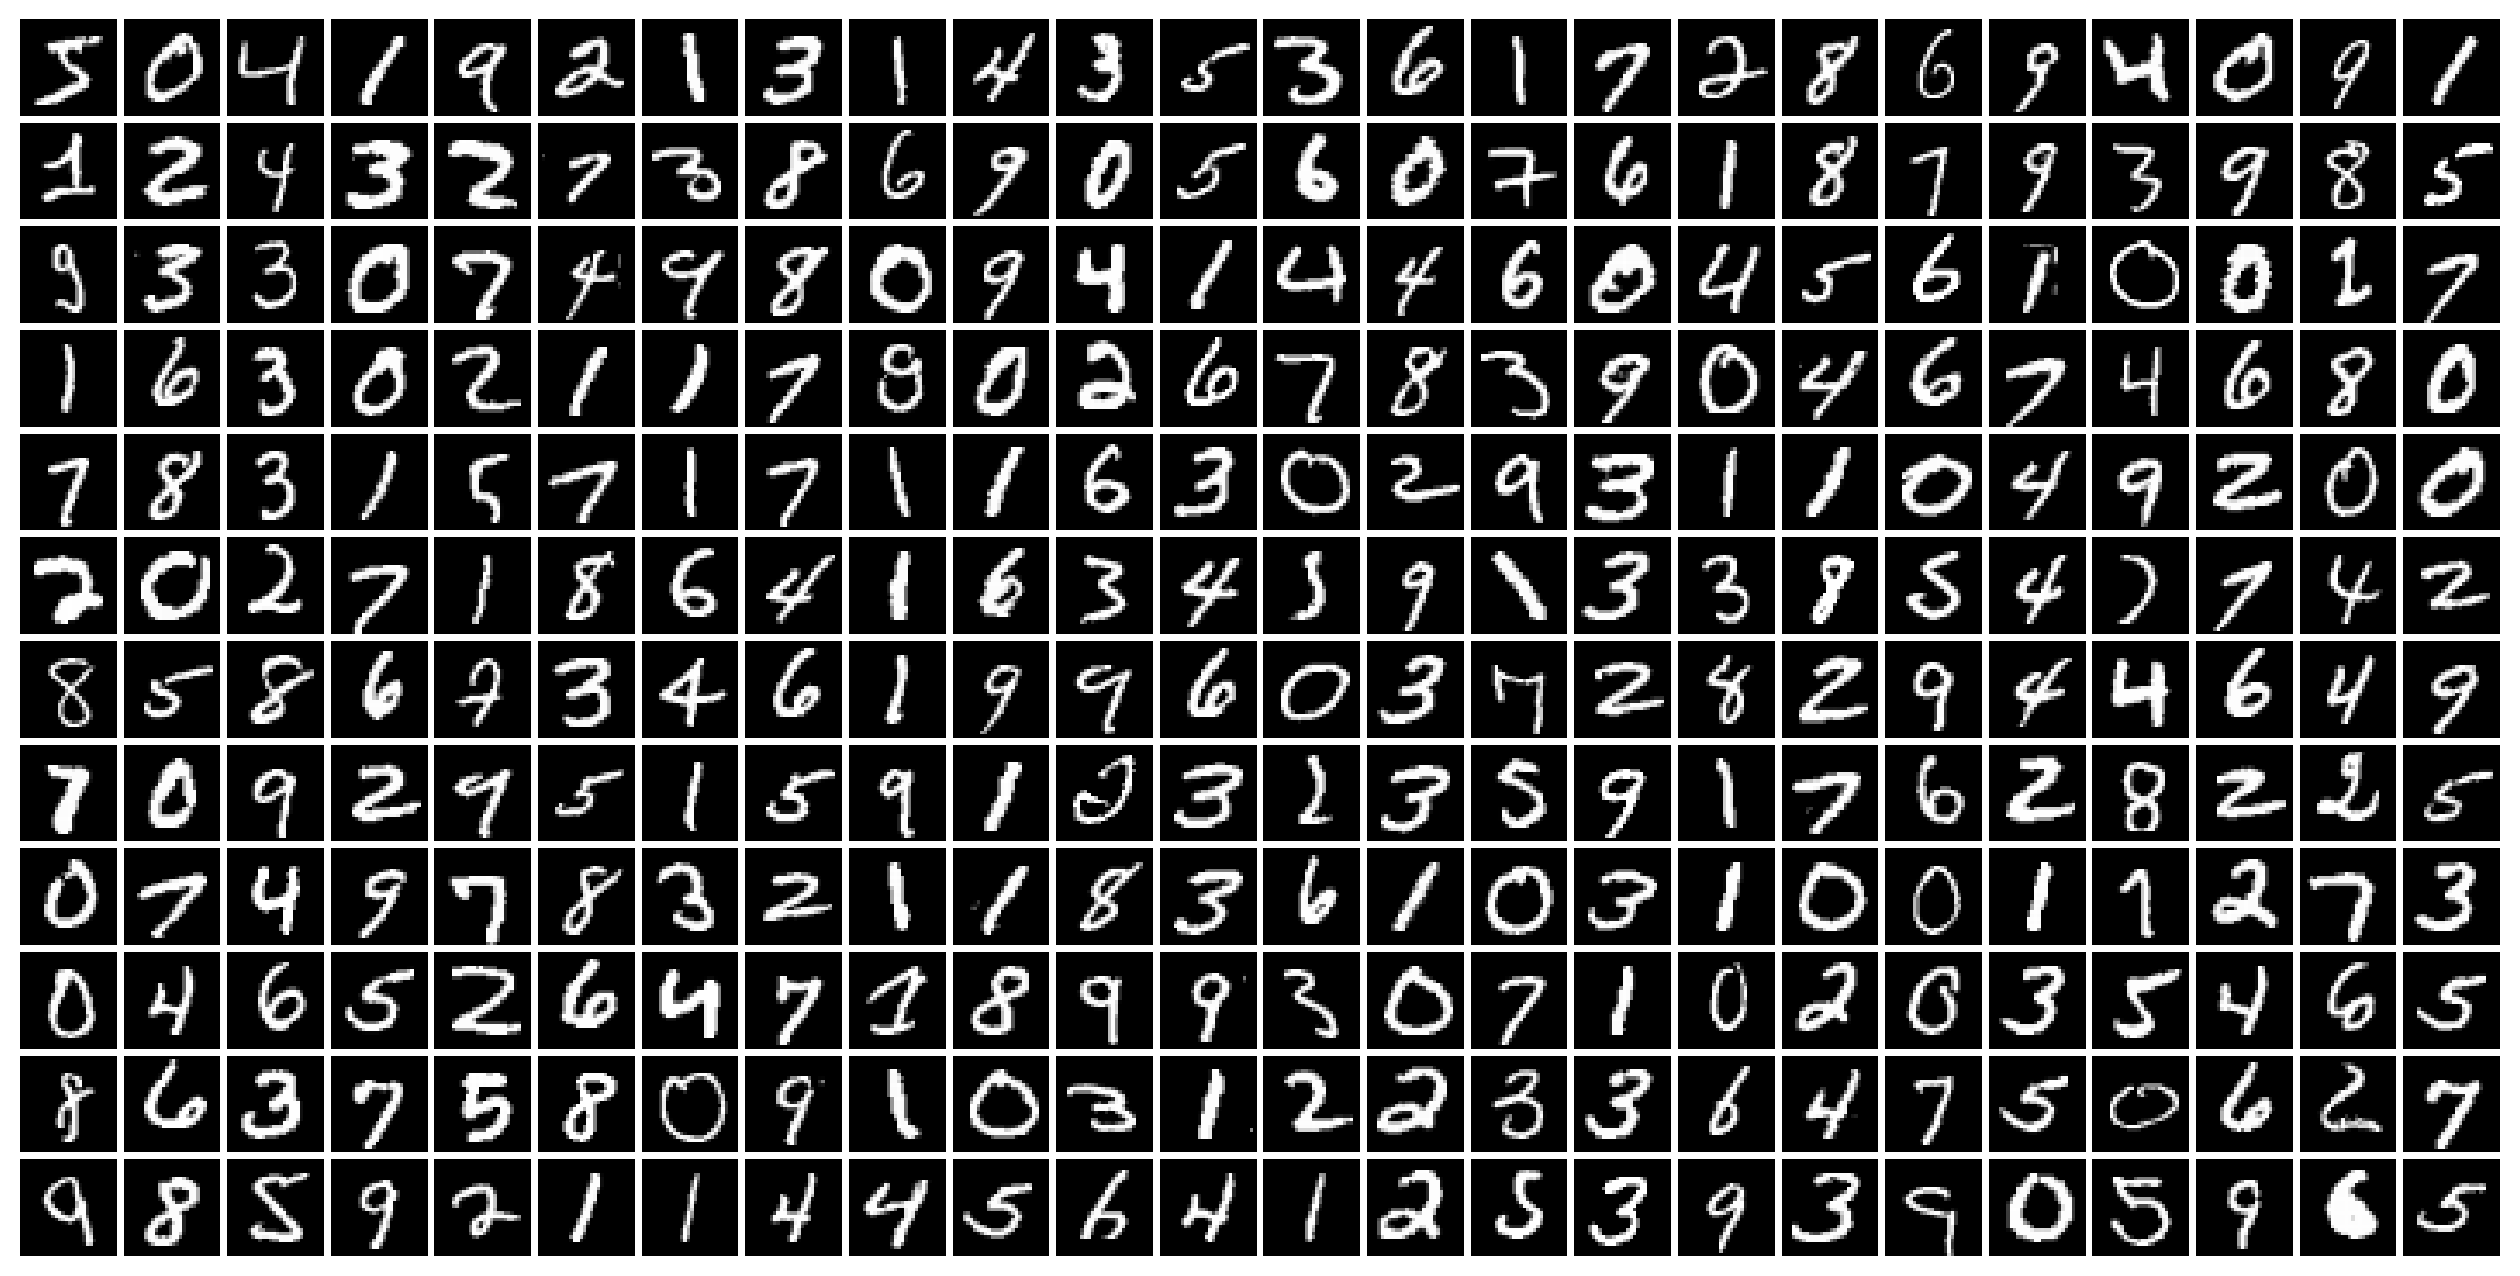

In [26]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# MLP training

In [27]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [28]:
def limit_weights(w: NDArray, λ: float) -> NDArray:
    if λ == 0:
        return w
    norm = np.linalg.norm(w, ord=2, axis=0)
    mask = norm > λ
    ρ = mask * (λ / norm) + (~mask) * 1.0
    return w * ρ

In [29]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x


class ReLU(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = np.maximum(0, x)
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (x > 0).astype(np.float32)
        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [30]:
class Linear(Layer):
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        weight_limit: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.weight_limit: float = weight_limit
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Biases initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # --- Apply weight limit normalization
        self.w = limit_weights(self.w, self.weight_limit)

        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [31]:
class Dropout(Layer):
    def __init__(self, p: float):
        assert 0 < p <= 1
        self.p: float = p
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None
        # Dropout mask, required for backpropagation
        self.mask: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        if training:
            # Save the dropout mask for backward pass
            self.mask = (rand(*x.shape) > self.p).astype(np.float32)
            self.y = x * self.mask
        else:
            self.y = x * (1 - self.p)
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * self.mask
        # --- Propagate ∂Loss/∂x backward
        return grad_x

### Forward pass

Calculate total input to the neurons. Then calculate activations (remember to add *ones* as the last column). Store result in `layer.activations`.

##### Computing derivatives of activation function

If `compute_derivatives` is set to `True`, we also need to compute the derivatives of the activation function and store them in `layer.d_activations`. We **do not** need to add *ones column* to the derivatives matrix! *Ones* are only needed in the activations matrix, where they are used to add biases to the total input of neurons in the next hidden layer.

##### Dropout

If `compute_derivatives` is set to `True` and the dropout rate in the input layer is greater than 0, we need to calculate the dropout mask for the MLP input and apply it to `batch`.

When calculating hidden activations in an MLP layer, check whether dropout rate in the next layer is greater then 0. If yes, then we need to apply dropout to the calculated activations (and derivatives of activations). In this case:
* construct dropout mask for the hidden layer,
* apply this mask to where it is needed in the hidden layer.

Do **not** apply dropout to the last column in activations or input batch, as they contains fixed *ones*.

In [32]:
def forward_pass(mlp: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in mlp:
        x = layer.forward(x, training=training)
    return x

### Error backpropagation

In [33]:
def error_backpropagate(mlp: Sequence[Layer], X_batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(mlp))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `X_batch` if i=0)
        x = mlp[i - 1].y if i > 0 else X_batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = mlp[i].backward(x, grad_y)

### Mean dropout network

Implement the weight scalling for the network that approximates MLP outputs under dropout.

In [34]:
# NOTE: This is not really necessary in our implementation.
# def mean_network(mlp):
#     mlp = [layer.deep_copy() for layer in mlp]
    
#     for layer in mlp:
#         raise Exception("Mean dropout network is not implemented!")
    
#     return mlp

### Training procedure

In [35]:
def classify(mlp: Sequence[Layer], X_batch: NDArray) -> NDArray:
    mlogits = forward_pass(mlp, X_batch, training=False)
    return np.argmax(mlogits, axis=1)


def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(16, -1, 28, 28)
    tiles(filters)

In [36]:
def train_mlp(mlp: Sequence[Layer], dataset: NDArray, labels: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size

    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)

    for batch_idx, (X_batch, t_batch) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        # NOTE: in this implementation mlp returns *mlogits* and not probabilities
        y = forward_pass(mlp, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the cross entropy function.
        # NOTE: in this implementation mlp returns *mlogits* and thus we need to pass `y` through
        # the softmax function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (softmax(y) - t_batch)

        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, X_batch, grad_y)

        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [37]:
def run_mlp_training(
    mlp: Sequence[Layer],
    X_train: NDArray,
    y_train: NDArray,
    X_valid: NDArray,
    y_valid: NDArray,
    batch_size: int,
    epochs_count: int,
    target_momentum: float = 0.95,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            for layer in filter(lambda l: isinstance(l, Linear), mlp):
                layer.momentum = target_momentum
        elif epoch == 170:  # (╭ರ_•́)
            for layer in filter(lambda l: isinstance(l, Linear), mlp):
                layer.momentum = 0.5
                layer.lr = 0.01

        start_time = time.time()
        train_mlp(mlp, X_train, y_train, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, X_valid)
        accuracy = np.sum(predictions == y_valid) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2%}".format(elapsed, accuracy))

    print("Training finished!")

# MNIST digits classification

In [38]:
DATASET_SIZE = 60_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

In [39]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 512

BATCH_SIZE = 128
EPOCHS_COUNT = 200

LEARNING_RATE = 0.03
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5

In [40]:
from IPython.core.display import HTML

def evaluate(mlp, train_set, train_labels,
             validation_set, validation_labels,
             batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in MLP</h3>'))
    draw_layer_filters(next(filter(lambda l: isinstance(l, Linear), mlp)))
    
    display(HTML('<h3>Largest norms of weight-vectors in MLP layers</h3>'))
    for i, layer in enumerate(filter(lambda l: isinstance(l, Linear), mlp)):
        max_norm = np.max(np.linalg.norm(layer.w, axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))

### Plain MLP (no dropout)

Epoch 1:	########################################	elapsed: 6.40s, accuracy: 93.84%
Epoch 2:	########################################	elapsed: 3.48s, accuracy: 95.55%
Epoch 3:	########################################	elapsed: 3.46s, accuracy: 96.49%
Epoch 4:	########################################	elapsed: 3.04s, accuracy: 96.90%
Epoch 5:	########################################	elapsed: 3.22s, accuracy: 97.11%
Epoch 6:	########################################	elapsed: 3.60s, accuracy: 97.29%
Epoch 7:	########################################	elapsed: 4.00s, accuracy: 97.61%
Epoch 8:	########################################	elapsed: 3.04s, accuracy: 97.40%
Epoch 9:	########################################	elapsed: 3.01s, accuracy: 97.65%
Epoch 10:	########################################	elapsed: 2.98s, accuracy: 97.94%
Epoch 11:	########################################	elapsed: 6.27s, accuracy: 98.50%
Epoch 12:	########################################	elapsed: 2.84s, accuracy: 98.19%
E

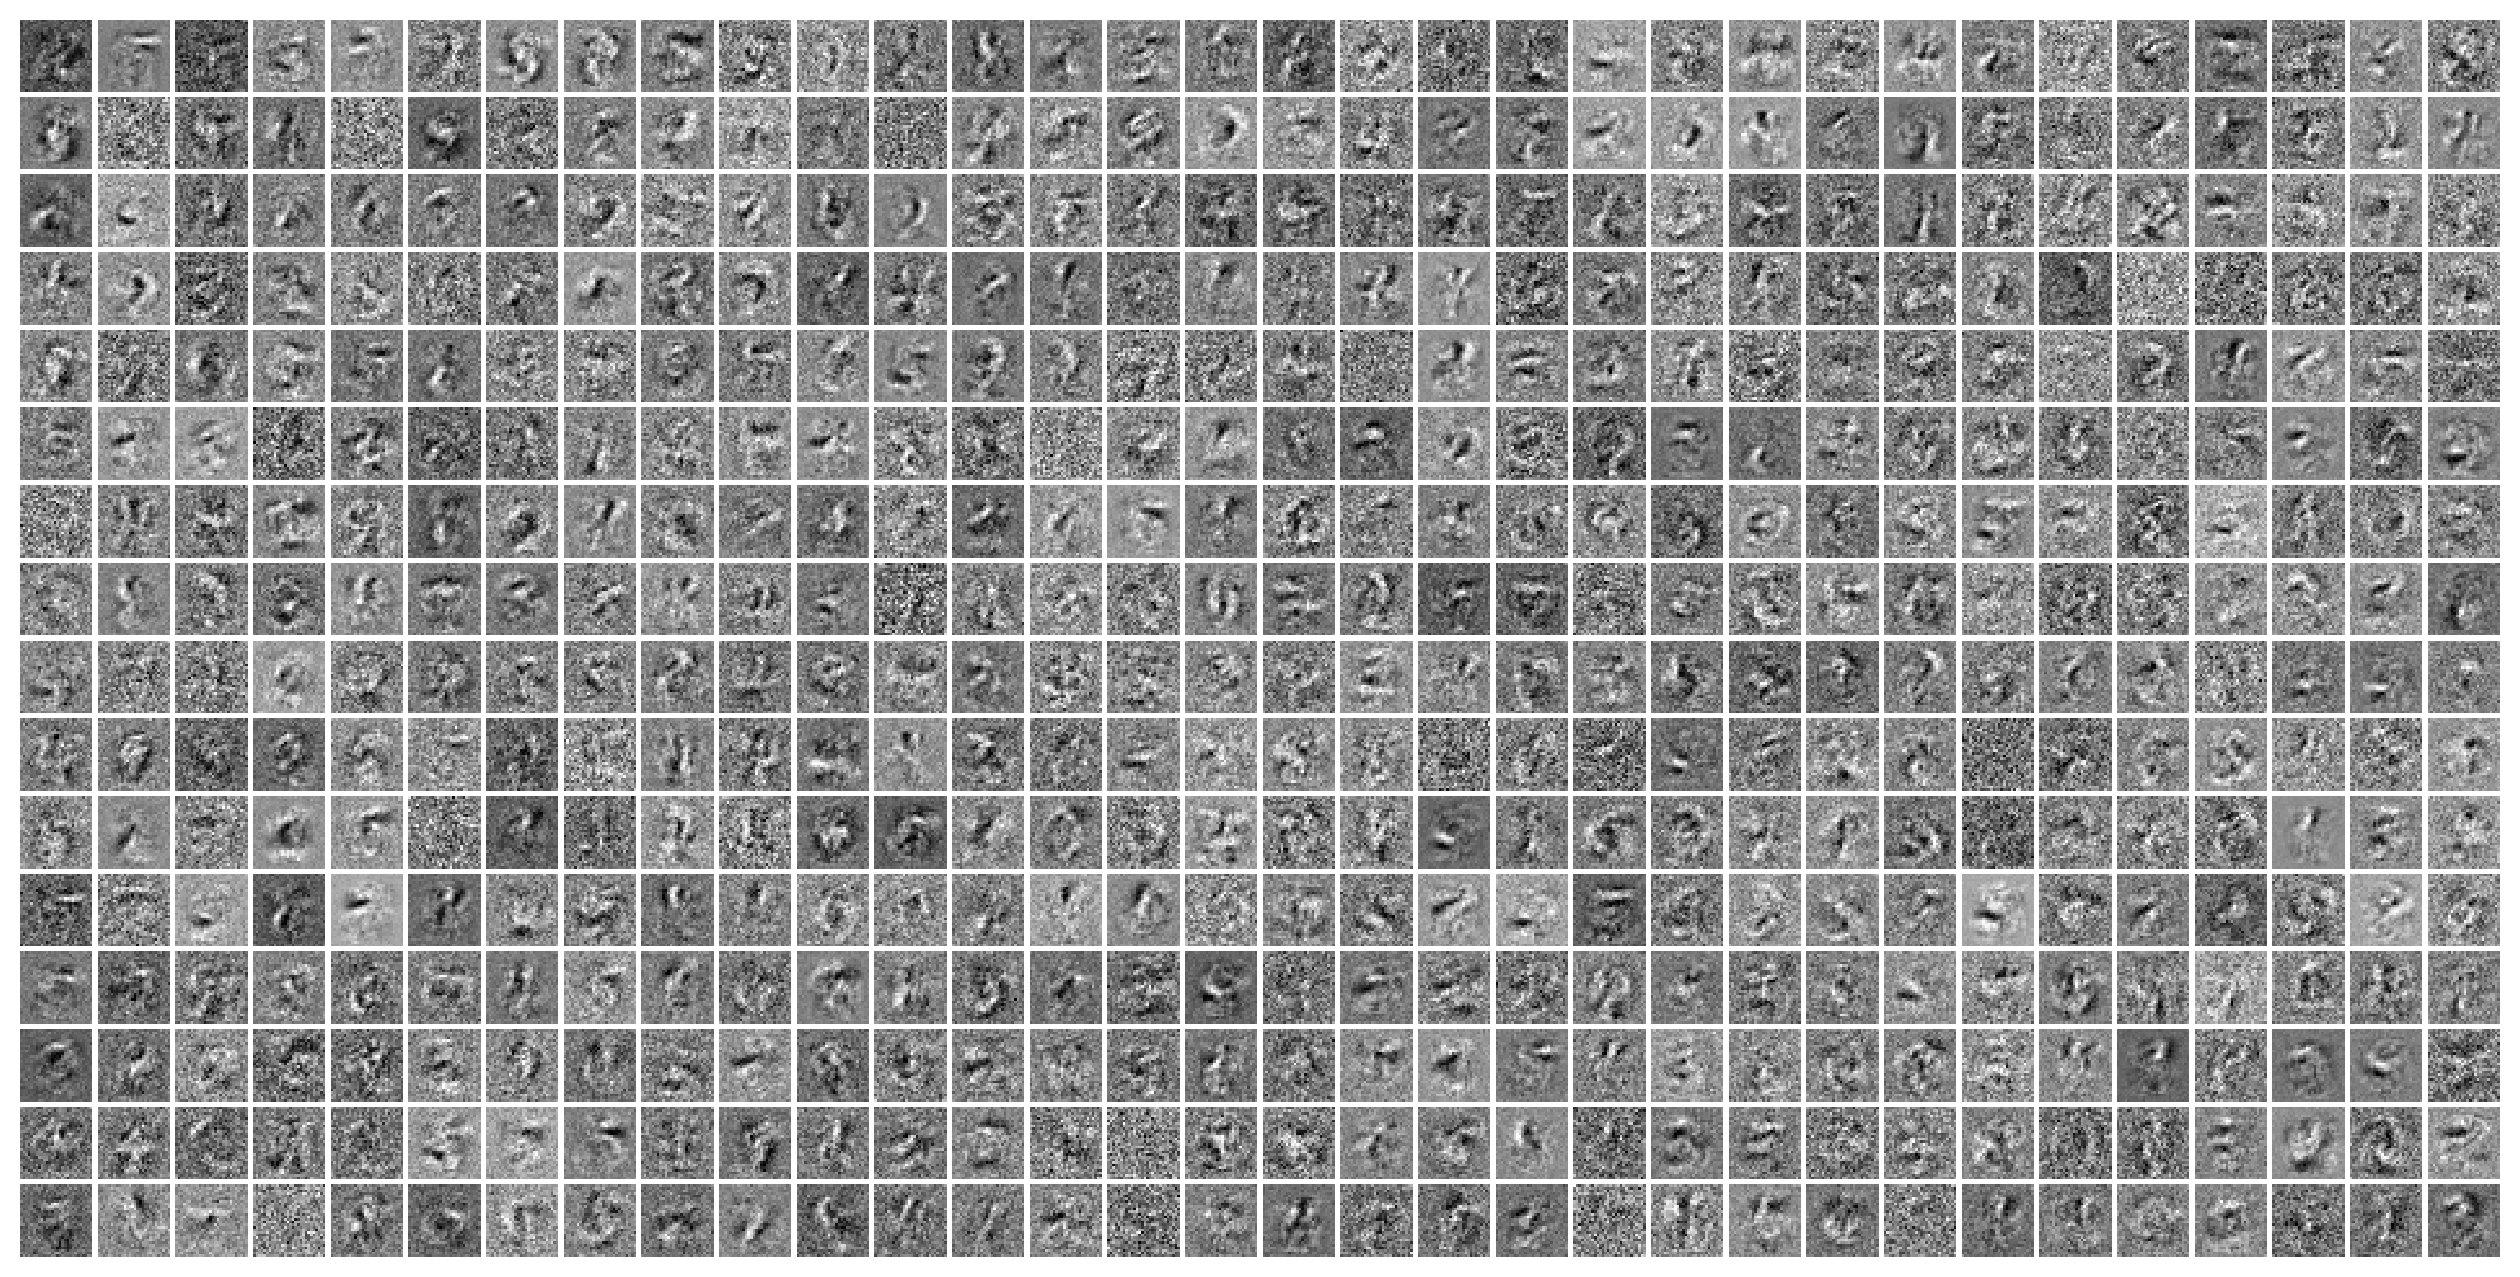

	layer 1: 1.00
	layer 2: 1.00
	layer 3: 4.00


In [41]:
# mlp = [
#     Layer( VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM, weight_limit=1.0),
#     Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM, weight_limit=1.0),
#     Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.0, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0),
# ]

mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0, init_method="He"),
]

evaluate(mlp, mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, BATCH_SIZE, EPOCHS_COUNT)

### MLP with dropout

Epoch 1:	########################################	elapsed: 4.25s, accuracy: 88.00%
Epoch 2:	########################################	elapsed: 4.15s, accuracy: 90.85%
Epoch 3:	########################################	elapsed: 3.80s, accuracy: 92.03%
Epoch 4:	########################################	elapsed: 3.88s, accuracy: 92.93%
Epoch 5:	########################################	elapsed: 6.72s, accuracy: 93.84%
Epoch 6:	########################################	elapsed: 3.99s, accuracy: 95.84%
Epoch 7:	########################################	elapsed: 3.94s, accuracy: 96.72%
Epoch 8:	########################################	elapsed: 3.64s, accuracy: 97.00%
Epoch 9:	########################################	elapsed: 3.93s, accuracy: 97.31%
Epoch 10:	########################################	elapsed: 3.71s, accuracy: 97.53%
Epoch 11:	########################################	elapsed: 3.71s, accuracy: 97.69%
Epoch 12:	########################################	elapsed: 3.66s, accuracy: 97.72%
E

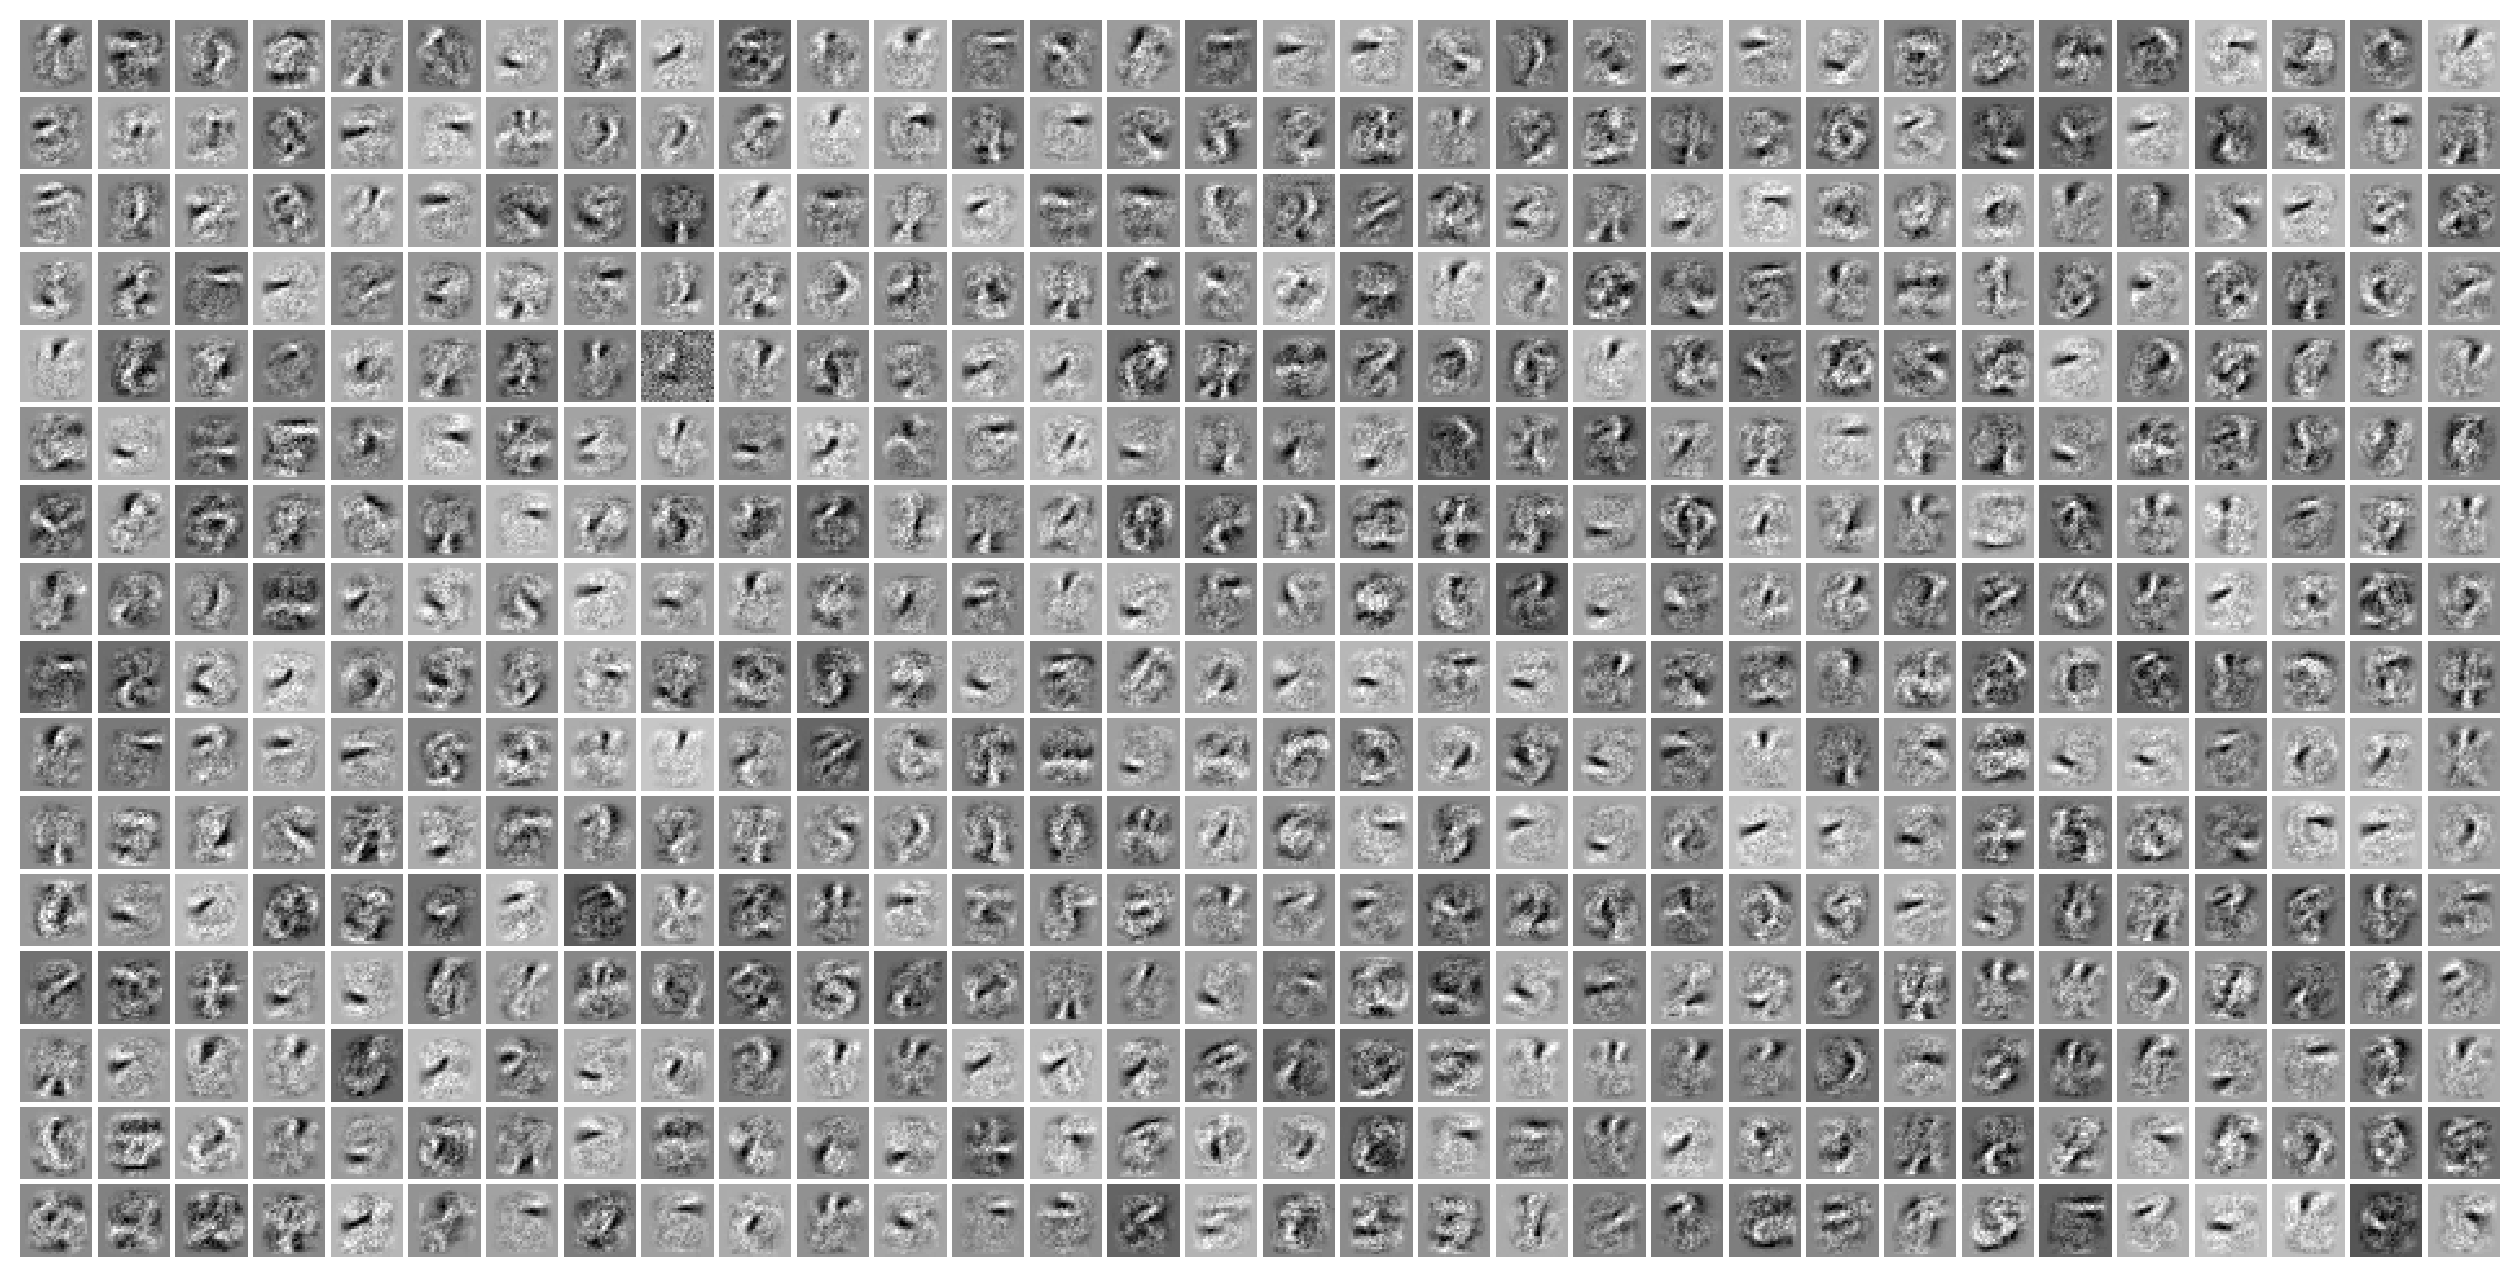

	layer 1: 1.00
	layer 2: 1.00
	layer 3: 4.00


In [42]:
# mlp_with_dropout = [
#     Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.2, LEARNING_RATE, MOMENTUM, weight_limit=1.0),
#     Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.5, LEARNING_RATE, MOMENTUM, weight_limit=1.0),
#     Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.5, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0),
# ]

mlp_with_dropout = [
    Dropout(p=0.2),
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Dropout(p=0.5),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Dropout(p=0.5),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0, init_method="He"),
]

evaluate(
    mlp_with_dropout,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    BATCH_SIZE,
    EPOCHS_COUNT,
)